## Empirical Bayes experiments - different datasets and prior weightings

### Step 0: packages

In [21]:
# test modification

library(data.table)
library(tidyverse)
library(distr)

### Step 1: load in the data and split it into train and test sets

In [22]:
# raw_df = read.csv("data/Gift_Cards.csv", header = FALSE, col.names=c("item", "user", "rating", "timestamp"))
raw_df = read.csv("data/Video_Games_raw.csv", header = FALSE, col.names=c("item", "user", "rating", "timestamp"))
# raw_df = read.csv("data/Prime_Pantry.csv", header = FALSE, col.names=c("item", "user", "rating", "timestamp"))
head(raw_df)

set.seed(1729)

df <- raw_df %>% 
  select(c("item", "rating"))

counts <- count(df, item) %>%
  filter(n > 20)

df = merge(counts, df, by="item")
in.train = sample(unique(df$item), size = 0.6*length(unique(df$item)))
df.train = filter(df, item %in% in.train)
df.test = filter(df, !item %in% in.train)

,item,user,rating,timestamp
,<chr>,<chr>,<dbl>,<int>
1,0439381673,A21ROB4YDOZA5P,1,1402272000
2,0439381673,A3TNZ2Q5E7HTHD,3,1399680000
3,0439381673,A1OKRM3QFEATQO,4,1391731200
4,0439381673,A2XO1JFCNEYV3T,1,1391731200
5,0439381673,A19WLPIRHD15TH,4,1389830400
6,0439381673,A1TLA7XXSZMTS7,5,1389052800


### Step 2: Train the EB model (categorical with Dirichlet prior)

In [23]:
prior_df <- dcast(setDT(df.train), item ~ rating, fun.aggregate = length)

colnames(prior_df) <- c("item", "n1", "n2", "n3", "n4", "n5")

prior_df$n = prior_df$n1 + prior_df$n2 + prior_df$n3 + prior_df$n4 + prior_df$n5

prior_df <- filter(prior_df, n > 20)

# remove all columns with a 0 count for one category
prior_df  <- transmute(prior_df, n1 = n1 / n, n2 = n2 / n, n3 = n3 / n, n4 = n4 / n, n5 = n5 / n) %>% 
  filter(n1 != 0 & n2 != 0 & n3 != 0 & n4 != 0 & n5 != 0)

log_p <- summarize(prior_df, summarize(prior_df, n1 = sum(log(n1)), n2 = sum(log(n2)), n3 = sum(log(n3)), n4=sum(log(n4)), n5=sum(log(n5))))
log_p <- as.numeric(log_p[1,])

print(log_p)
# gift cards log-p: -558.81647 -798.35765 -708.34644 -518.60578  -36.76743
# video games log-p: -19110.579 -23947.009 -20340.458 -15104.914  -5944.121
# prime pantry log-p: -5113.2916 -5570.4004 -4816.4874 -3816.7264  -770.3125

N <- nrow(prior_df)

# start from a totally uninformed prior
alphas = c(1,1,1,1,1)

# actual training function

fp_step <- function(alphas, log_p, N) {
  return(igamma(rep(digamma(sum(alphas)), 5) + log_p/N))
}

[1] -19110.579 -23947.009 -20340.458 -15104.914  -5944.121


In [24]:
# this step must be repeated many times.
# gift card alphas: 18.41389   4.77803   7.56642  21.55294 309.98082
# video game alphas: 2.026083 1.318121 1.806632 3.009980 8.200924
# prime pantry alphas: 2.360188  1.927949  2.705008  4.389483 22.445298
alphas <- fp_step(alphas, log_p, N)
b = sum(alphas)
print(alphas)

[1] 0.8678302 0.6387422 0.7986619 1.1673404 2.6695574


In [25]:
# check if stability achieved

for (i in c(1:100)) {
    alphas <- fp_step(alphas,log_p,N)
}
print(alphas)

[1] 2.026079 1.318119 1.806630 3.009975 8.200909


### Step 3: Prepare the various testing methods

In [26]:
temp = filter(raw_df, item %in% df.test$item)
df.test <- merge(counts, temp, by="item")

df.test <- filter(df.test, n >= 100) %>%
  group_by(item) %>% 
  arrange(timestamp, .by_group = TRUE) %>%
  slice_head(n=100)

#split test set in half
df.test_learn = group_by(df.test, item) %>% 
  arrange(timestamp, .by_group = TRUE) %>%
  slice_head(n=50)
df.test_eval = group_by(df.test, item) %>% 
  arrange(timestamp, .by_group = TRUE) %>%
  slice_tail(n=50)

# set up evaluation dataset for evaluating
df.test_eval <- dcast(setDT(df.test_eval), item ~ rating, fun.aggregate = length) %>% arrange(item)
colnames(df.test_eval) <- c("item", "n1", "n2", "n3", "n4", "n5")
df.test_eval$n = df.test_eval$"n1" + df.test_eval$"n2" + df.test_eval$"n3" + df.test_eval$"n4" + df.test_eval$"n5"
df.test_eval <- transmute(df.test_eval, item=item, n1 = n1 / n, n2 = n2 / n, n3 = n3 / n, n4 = n4 / n, n5 = n5 / n)

num_eval_products = nrow(df.test_eval)

#### Step 3.1 - Over-time test of EB compared with frequentist

In [11]:
# start training and checking performance at each step
items = unique(df.test_learn$item)

mses_f = tibble(items)
mses_b = tibble(items)
kls_f = tibble(items)
kls_b = tibble(items)

for (i in c(1:50)) {
  df.test_learn_subset = group_by(df.test_learn, item) %>%
    arrange(timestamp, .by_group = TRUE) %>%
    slice_head(n=i)

  df.test_learn_subset <- dcast(setDT(df.test_learn_subset), item ~ rating, fun.aggregate = length, drop=FALSE) %>% arrange(item)
  
  # adding missing columns
  for (j in setdiff(c("item", "1", "2", "3", "4", "5"), colnames(df.test_learn_subset))) {
    df.test_learn_subset[[j]] <- rep(0, num_eval_products)
  }
  df.test_learn_subset <- df.test_learn_subset[,c("item", "1", "2", "3", "4", "5")]
  
  colnames(df.test_learn_subset) <- c("item", "n1", "n2", "n3", "n4", "n5")
  df.test_learn_subset$n = df.test_learn_subset$"n1" + df.test_learn_subset$"n2" + df.test_learn_subset$"n3" + df.test_learn_subset$"n4" + df.test_learn_subset$"n5"

  df.test_learn_f <- transmute(df.test_learn_subset, item=item, avg = (n1+n2*2+n3*3+n4*4+n5*5)/n, n1 = n1 / n, n2 = n2 / n, n3 = n3 / n, n4 = n4 / n, n5 = n5 / n)
  df.test_learn_b <- mutate(df.test_learn_subset, item=item, b1 = n1 + alphas[1], b2 = n2 + alphas[2], b3 = n3 + alphas[3],
         b4 = n4 + alphas[4], b5 = n5 + alphas[5], b = n + sum(alphas))
  df.test_learn_b <- transmute(df.test_learn_b, item=item, avg = (b1+b2*2+b3*3+b4*4+b5*5)/n, b1 = b1 / b, b2 = b2 / b, b3 = b3 / b, b4 = b4 / b, b5 = b5 / b)
    
  df.test_learn_f <- df.test_learn_f %>% select(-c(item, avg))
  df.test_learn_b <- df.test_learn_b %>% select(-c(item, avg))
    
  df.test_eval_modified <- select(df.test_eval, -c(item))

  f_mse = rowSums((df.test_learn_f - df.test_eval_modified)^2)
  b_mse = rowSums((df.test_learn_b - df.test_eval_modified)^2)
  f_kl = rowSums(df.test_eval_modified*log(df.test_eval_modified/df.test_learn_f), na.rm = TRUE)
  f_kl[!is.finite(f_kl)] = 1
  b_kl = rowSums(df.test_eval_modified*log(df.test_eval_modified/df.test_learn_b), na.rm = TRUE)
  b_kl[!is.finite(b_kl)] = 1
  
  mses_f[[i]] = f_mse
  mses_b[[i]] = b_mse
  kls_f[[i]] = f_kl
  kls_b[[i]] = b_kl

}

mses_f = tibble(val = colSums(mses_f) / num_eval_products, method = "freq", idx=c(1:length(mses_f)))
mses_b = tibble(val = colSums(mses_b) / num_eval_products, method = "eb", idx=c(1:length(mses_b)))
kls_f = tibble(val = colSums(kls_f) / num_eval_products, method = "freq", idx=c(1:length(kls_f)))
kls_b = tibble(val = colSums(kls_b) / num_eval_products, method = "eb", idx=c(1:length(kls_b)))

mses = rbind(mses_f,mses_b)
kls = rbind(kls_f,kls_b)

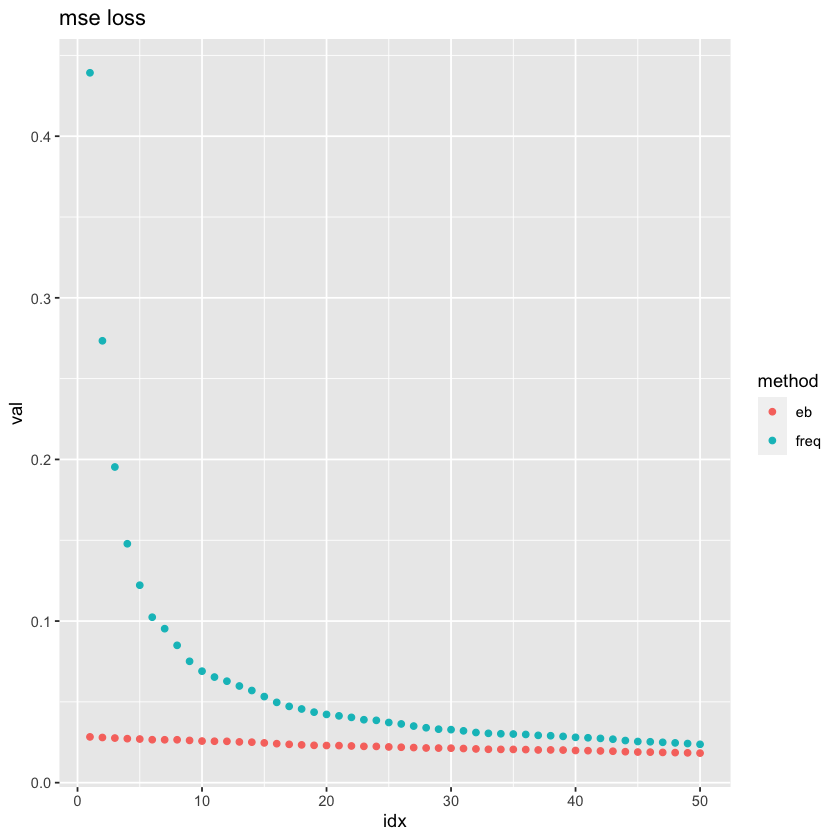

In [12]:
# Plot MSE loss

ggplot(mses, aes(x=idx, y=val, color=method)) +
  geom_point() +
  ggtitle("mse loss")

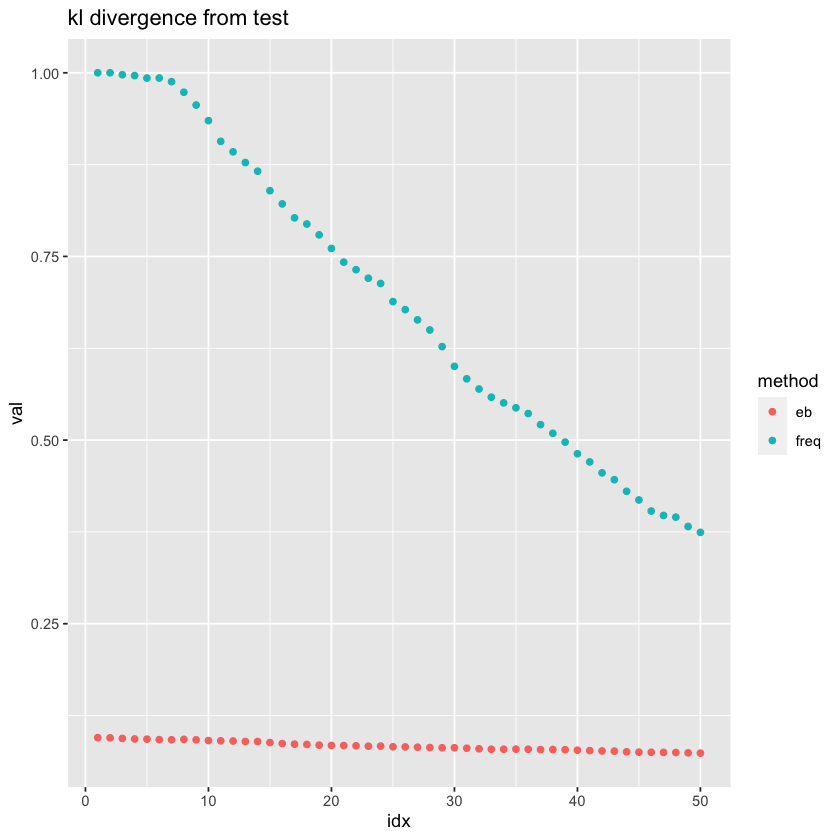

In [13]:
# Plot kl divergence

ggplot(kls, aes(x=idx, y=val, color=method)) +
  geom_point() +
  ggtitle("kl divergence from test")

#### Step 3.2 Facet grid of MSE loss over train sample stratified by average rating

In [27]:
test_learn_agg <- dcast(setDT(df.test_learn), item ~ rating, fun.aggregate = length)
colnames(test_learn_agg) <- c('item', 'n1', 'n2', 'n3', 'n4', 'n5')
test_learn_agg <- test_learn_agg %>% mutate(n = n1 + n2 + n3 + n4 + n5)
test_learn_agg <- transmute(test_learn_agg, item=item, n1 = n1 / n, n2 = n2 / n, n3 = n3 / n, n4 = n4 / n, n5 = n5 / n)

In [28]:
test_subset = rbind(df.test_eval, test_learn_agg) %>% mutate(avg = n1+2*n2+3*n3+4*n4+5*n5)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



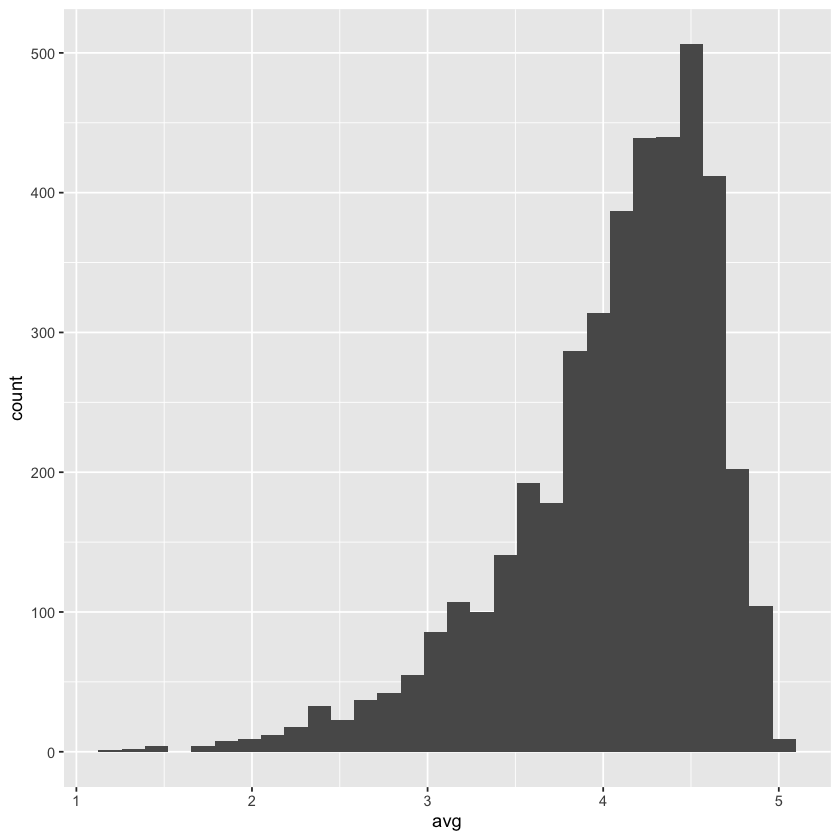

In [29]:
ggplot(test_subset, aes(x=avg)) +
    geom_histogram()

In [30]:
set.seed(1729)

num_prods = 20

test_subset_1 <- test_subset %>% filter(!duplicated(item)) %>% filter(avg <= 2) 
test_subset_1 <- test_subset_1 %>% sample_n(min(num_prods, nrow(test_subset_1))) 
test_subset_2 <- test_subset %>% filter(!duplicated(item)) %>% filter(avg <= 3, avg > 2) 
test_subset_2 <- test_subset_2 %>% sample_n(min(num_prods, nrow(test_subset_2)))
test_subset_3 <- test_subset %>% filter(!duplicated(item)) %>% filter(avg <= 4, avg > 3) 
test_subset_3 <- test_subset_3 %>% sample_n(min(num_prods, nrow(test_subset_3)))
test_subset_4 <- test_subset %>% filter(!duplicated(item)) %>% filter(avg > 4) 
test_subset_4 <- test_subset_4 %>% sample_n(min(num_prods, nrow(test_subset_4)))

# this is the list of items, along with their average score, that we will test

test_subset <- rbind(test_subset_1, test_subset_2, test_subset_3, test_subset_4)
print(nrow(test_subset))

[1] 71


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



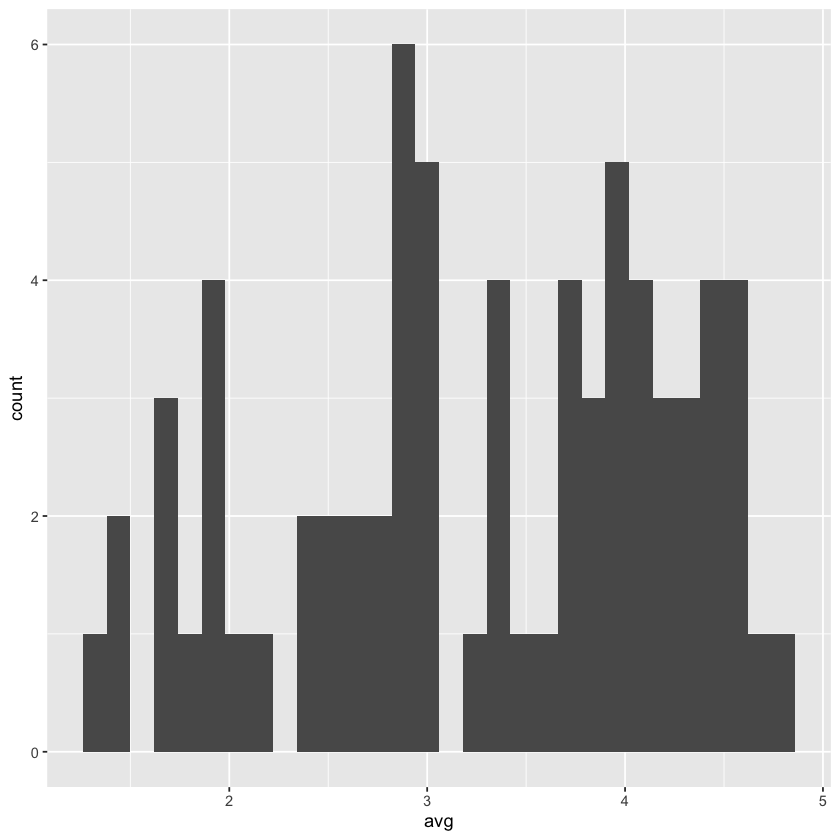

In [31]:
ggplot(test_subset, aes(x=avg)) +
    geom_histogram()

In [32]:
duplicated(test_subset$item)

[1] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[13] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[25] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[37] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[49] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[61] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE

In [33]:
results_df = data.frame(matrix(ncol=5,nrow=0))

for (i in c(10, 20, 30, 40, 50)) {
  df.test_learn_subset = group_by(df.test_learn, item) %>%
    filter(item %in% test_subset$item) %>%
    arrange(timestamp, .by_group = TRUE) %>%
    slice_head(n=i)
    
  df.test_learn_subset <- dcast(setDT(df.test_learn_subset), item ~ rating, fun.aggregate = length, drop=FALSE) %>% arrange(item)
  
  # adding missing columns
  for (j in setdiff(c("item", "1", "2", "3", "4", "5"), colnames(df.test_learn_subset))) {
    df.test_learn_subset[[j]] <- rep(0, num_eval_products)
  }
  df.test_learn_subset <- df.test_learn_subset[,c("item", "1", "2", "3", "4", "5")]
    
  colnames(df.test_learn_subset) <- c("item", "n1", "n2", "n3", "n4", "n5")
  df.test_learn_subset$n = df.test_learn_subset$"n1" + df.test_learn_subset$"n2" + df.test_learn_subset$"n3" + df.test_learn_subset$"n4" + df.test_learn_subset$"n5"
    
  df.test_learn_f <- transmute(df.test_learn_subset, item=item, avg = (n1+n2*2+n3*3+n4*4+n5*5)/n, n1 = n1 / n, n2 = n2 / n, n3 = n3 / n, n4 = n4 / n, n5 = n5 / n)
  df.test_learn_b <- mutate(df.test_learn_subset, item=item, b1 = n1 + alphas[1], b2 = n2 + alphas[2], b3 = n3 + alphas[3],
         b4 = n4 + alphas[4], b5 = n5 + alphas[5], b = n + sum(alphas))
  df.test_learn_b <- transmute(df.test_learn_b, item=item, avg = (b1+b2*2+b3*3+b4*4+b5*5)/n, b1 = b1 / b, b2 = b2 / b, b3 = b3 / b, b4 = b4 / b, b5 = b5 / b)
    
  for (id in unique(test_subset$item)) {
      dist_b = filter(df.test_learn_b, item==id) %>% select(c(b1, b2, b3, b4, b5))
      dist_f = filter(df.test_learn_f, item==id) %>% select(c(n1, n2, n3, n4, n5))
      av = filter(test_subset, item==id)$avg
      dist_eval = filter(df.test_eval, item==id) %>% select(c(n1, n2, n3, n4, n5))
      
      to_add = c(id, sqrt(sum((dist_eval-dist_b)^2)), drop(av), i, 'eb')
      
      results_df <- rbind(results_df, to_add)
      
      to_add = c(id, sqrt(sum((dist_eval-dist_f)^2)), drop(av), i, 'freq')
      
      results_df <- rbind(results_df, to_add)
      
  }

}

colnames(results_df) <- c('item', 'dist', 'avg', 'num_train', 'method')

In [34]:
results_df

item,dist,avg,num_train,method
<chr>,<chr>,<chr>,<chr>,<chr>
B00178630A,0.590485277904813,1.68,10,eb
B00178630A,0.468187996428785,1.68,10,freq
B00ZQD7VNK,0.662392624524096,1.72,10,eb
B00ZQD7VNK,0.634980314655502,1.72,10,freq
B016NZFGP4,0.560909819813014,1.86,10,eb
B016NZFGP4,0.437264222181509,1.86,10,freq
B00QXJFE08,0.508837101319774,1.92,10,eb
B00QXJFE08,0.342928563989645,1.92,10,freq
B000053UJ2,0.722427311054742,1.48,10,eb


In [35]:
nrow(results_df)

[1] 710

In [36]:
results_df$dist <- as.numeric(results_df$dist)
results_df$avg <- as.numeric(results_df$avg)

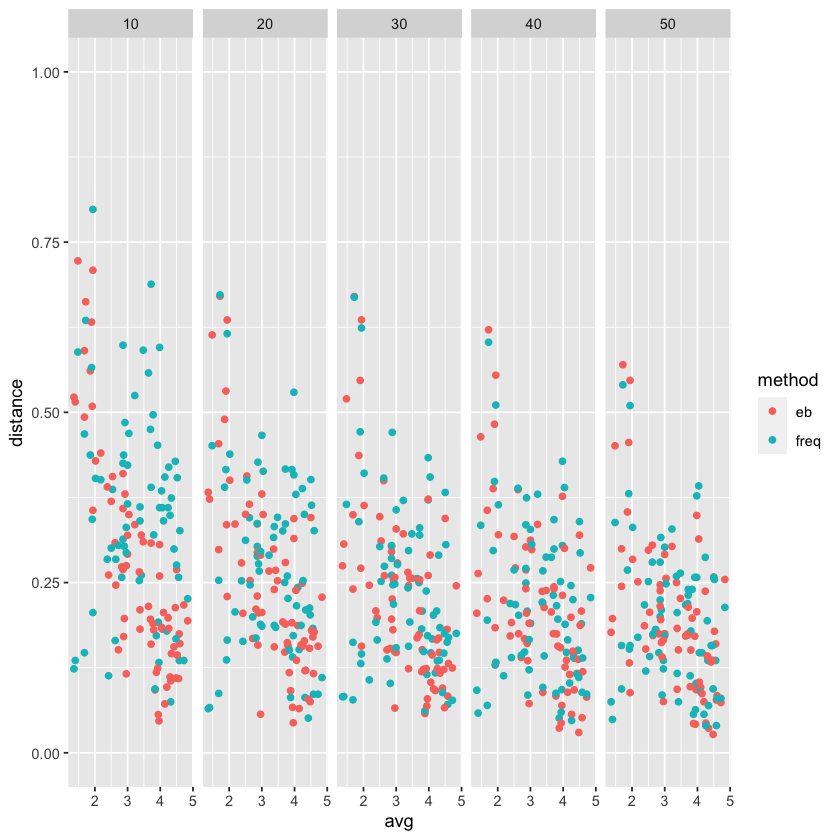

In [37]:
# Plot results

ggplot(results_df) + 
    geom_point(aes(x=avg, y=dist, color=method)) +
    facet_wrap(vars(num_train), ncol=5) +
    scale_y_continuous(name="distance", limits=c(0, 1))

In [38]:
avg_df <- results_df %>% 
           mutate(level=floor(avg*2)/2) %>%
#           mutate(level=floor(avg)) %>%
          group_by(level, method, num_train) %>%
          summarize(mean_dist=mean(dist), std = sd(dist), n=dplyr::n())

`summarise()` has grouped output by 'level', 'method'. You can override using the `.groups` argument.



In [39]:
avg_df

level,method,num_train,mean_dist,std,n
<dbl>,<chr>,<chr>,<dbl>,<dbl>,<int>
1.0,eb,10,0.5866848,0.11760567,3
1.0,eb,20,0.4563015,0.13640728,3
1.0,eb,30,0.3669732,0.13331180,3
1.0,eb,40,0.3107652,0.13588298,3
1.0,eb,50,0.2750088,0.15267925,3
1.0,freq,10,0.2824975,0.26512782,3
1.0,freq,20,0.1940463,0.22252881,3
1.0,freq,30,0.1765688,0.16299854,3
1.0,freq,40,0.1614580,0.15048906,3


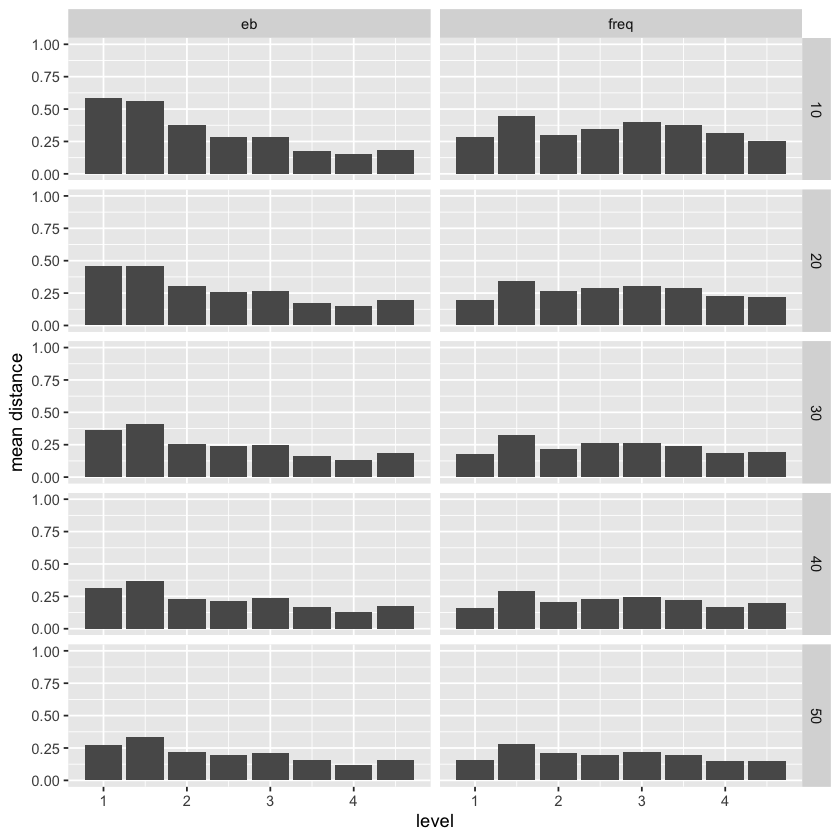

In [40]:
# Plotting averages by buckets of 0.5

ggplot(avg_df) + 
    geom_bar(aes(x=level,y=mean_dist), stat='identity') +
    facet_grid(rows = vars(num_train), cols=vars(method)) +
    scale_y_continuous(name="mean distance", limits=c(0, 1))